**Nội dung bài thực hành**

Người học tiếp cận và giải quyết bài toán phân tích cảm xúc sử dụng 2 mô hình là RNN và GRU. Sau khi thực hành, người học có khả năng:
1. Sử dụng được Keras để cài đặt các mô hình mạng truy hồi
  

*   Thao tác với dữ liệu
*   Chuyển từ văn bản sang không gian vector qua mạng truy hồi


2. Áp dụng được RNN/ GRU cho bài toán phân tích cảm xúc


*   Huấn luyện mô hình
*   Đánh gía mô hình


3. Cải tiến được mô hình phân tích cảm xúc
3. Thực hành được với bài toán thực tế

**Thao tác với dữ liệu**



*   Bài thực hành sử dụng bộ dữ liệu IMDB review
*   Dữ liệu gồm 2 phần: tập huấn luyện và tập kiểm thử (train data và test data). Mỗi phần gồm có 25000 câu, đuợc phân vào 2 lớp cảm xúc tích cực (positive) và tiêu cực (negative)
*   Yêu cầu: xây dựng mô hình phân tích cảm xúc các đánh giá của nguời dùng dựa trên 2 mô hình RNN và GRU



## Chuẩn bị dữ liệu
### Download and unzip data 

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2020-12-04 05:48:49--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  23.8MB/s    in 3.6s    

2020-12-04 05:48:53 (22.4 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
# unzip downloaded file
import tarfile
tf = tarfile.open("aclImdb_v1.tar.gz")
tf.extractall()

In [ ]:
# Merge file
# test
import pandas as pd
import os
labels={"pos":1, "neg":0}
test_df = pd.DataFrame()
train_df = pd.DataFrame()

for l in ("pos", "neg"):
    path = "aclImdb/train/%s" %(l)
    for file in os.listdir(path):
        with open(os.path.join(path, file)) as infile:
            txt = infile.read()
        train_df = train_df.append([[txt, labels[l]]], ignore_index=True)
train_df.columns=["review", "sentiment"]

for l in ("pos", "neg"):
    path = "aclImdb/test/%s" %(l)
    for file in os.listdir(path):
        with open(os.path.join(path, file)) as infile:
            txt = infile.read()
        test_df = test_df.append([[txt, labels[l]]], ignore_index=True)
test_df.columns=["review", "sentiment"]

In [ ]:
train_df.sample(frac=1).head()

,review,sentiment
7865,"The film maybe goes a little far, but if you l...",1
14020,"Gillian Anderson is an arrogant, driven, caree...",0
5064,<br /><br />Presenting Lily Mars is one of a g...,1
13456,Awful movie. It's a shame that a few of Flande...,0
2873,I don't remember when I first heard about this...,1


In [ ]:
test_df.head()

,review,sentiment
0,"This Metro film is episodic, but nearly a cons...",1
1,If the caper genre owes a lot to Walter Huston...,1
2,"I chose ""The English Patient"" for a history ex...",1
3,Thirty years prior to THE DEER HUNTER came thi...,1
4,"I can not say this movie was a hilarious, but ...",1


### Làm sạch dữ liệu

Vì dữ liệu đuợc crawl trực tiếp từ trang web nên việc xoá các tag html hay các cảm xúc emotition là cần thiết

In [ ]:
import re
def preprocessor(text):
    text = re.sub(r"<[^>]>", '', text)
    emoticons = re.findall("(?:|;|=)(?:-)?(?:\)\(|D|P)", text)
    text = re.sub("[\W]+", " ", text.lower()) + \
            " ".join(emoticons).replace('-', '')
    return text.lower()
train_df["review"] = train_df["review"].apply(preprocessor)
test_df["review"] = test_df["review"].apply(preprocessor)

### Biễu diễn dữ liệu

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


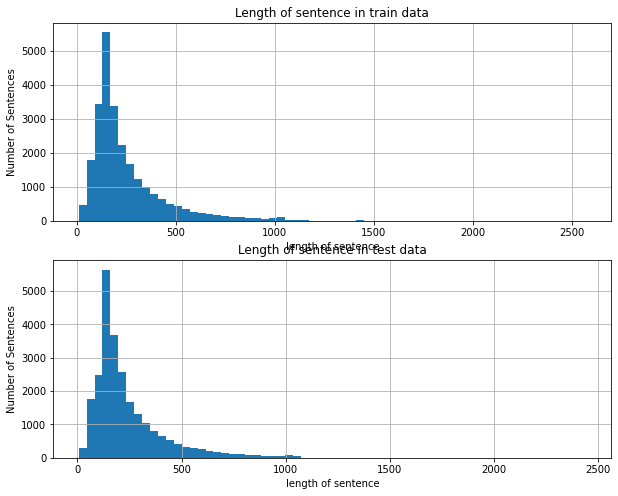

In [ ]:
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('punkt')
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.hist([len(word_tokenize(sent)) for sent in train_df["review"]], bins=64)
plt.xlabel("length of sentence")
plt.ylabel("Number of Sentences")
plt.title("Length of sentence in train data")
plt.grid()
plt.subplot(2,1,2)
plt.hist([len(word_tokenize(sent)) for sent in test_df["review"]], bins=64)
plt.xlabel("length of sentence")
plt.ylabel("Number of Sentences")
plt.title("Length of sentence in test data")
plt.grid()

### Config
Chuẩn bị các tham số cho mô hình

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.recurrent import GRU, SimpleRNN
# from keras.layers import CuDNNGRU # comment dong nay neu may ban khong ho tro CuDNN
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.layers import Input, TimeDistributed, BatchNormalization
from keras.layers.core import Activation, Dense, Dropout
from keras.layers.wrappers import Bidirectional

from keras import backend as K


max_len = 500
num_words = 5000
embedding_dim = 300
dropout = 0.2
hidden_dim = 750
l2_reg = 1e-4
batch_size = 64
epochs = 10
learning_rate = 1e-3
rnnact = 'tanh'
rnninit = 'glorot_uniform'
bidi = True
bidi_mode = 'concat' # one of {'sum', 'mul', 'concat', 'ave'}
finalact = 'sigmoid'
rnn = SimpleRNN
gru = GRU # chuyen thanh GRU neu may ban khong ho tro CuDNN
opt = 'adadelta'



### Sentence vectorize

In [ ]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_df["review"])

In [ ]:
X_train = tokenizer.texts_to_sequences(train_df["review"])
X_test = tokenizer.texts_to_sequences(test_df["review"])
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

## Sentiment Analysis using Keras
### Basic RNN cell

In [ ]:
def sa_by_basicrnn():
    # input layer
    input_s = Input(name='input_si', shape=(max_len,), dtype='int32')
    # create random word embedding
    shared_embedding = Embedding(name='emb', input_dim=num_words, input_length=max_len,
                                output_dim=embedding_dim, mask_zero=False, trainable=True)
    emb_s = shared_embedding(input_s)
    emb_s = Dropout(dropout, noise_shape=(None, max_len, embedding_dim))(emb_s)
    # rnn layer
    if bidi:
        shared_rnn = Bidirectional(
            rnn(hidden_dim, kernel_initializer=rnninit, input_shape=(None, max_len, embedding_dim), 
                                   return_sequences=False, name='rnn'),
            merge_mode=bidi_mode)
        rnn_dim = hidden_dim * 2
    else:
        shared_rnn = rnn(hidden_dim, kernel_initializer=rnninit, input_shape=(None, max_len, embedding_dim), 
                                   return_sequences=False, name='rnn')
        rnn_dim = hidden_dim
        
    rnn_s = shared_rnn(emb_s)
    rnn_s = Dropout(dropout, noise_shape=(None, rnn_dim ))(rnn_s)
    # final projection layer
    final_s = Dense(1, activation=finalact)(rnn_s)
    rnn_model = Model(inputs=input_s, outputs=final_s)
    rnn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return rnn_model
    
    

In [ ]:
def sa_by_GRU():
    # input layer
    input_s = Input(name='input_si', shape=(max_len,), dtype='int32')
    # create random word embedding
    shared_embedding = Embedding(name='emb', input_dim=num_words, input_length=max_len,
                                output_dim=embedding_dim, mask_zero=False, trainable=True)
    emb_s = shared_embedding(input_s)
    emb_s = Dropout(dropout, noise_shape=(None, max_len, embedding_dim))(emb_s)
    # rnn layer
    if bidi:
        shared_gru = Bidirectional(
            gru(hidden_dim, kernel_initializer=rnninit, input_shape=(None, max_len, embedding_dim), 
                                   return_sequences=False, name='rnn'),
            merge_mode=bidi_mode)
        gru_dim = hidden_dim * 2
    else:
        shared_gru = gru(hidden_dim, kernel_initializer=rnninit, input_shape=(None, max_len, embedding_dim), 
                                   return_sequences=False, name='rnn')
        gru_dim = hidden_dim
        
    gru_s = shared_gru(emb_s)
    gru_s = Dropout(dropout, noise_shape=(None,gru_dim ))(gru_s)
    # final projection layer
    final_s = Dense(1, activation=finalact)(gru_s)
    rnn_model = Model(inputs=input_s, outputs=final_s)
    rnn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return rnn_model
    
    

In [ ]:
model = sa_by_GRU() # co the chuyen thanh sa_by_basicrnn
print(model.summary())
model.fit(X_train, train_df["sentiment"], validation_split=0.2, batch_size=batch_size, epochs=epochs)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_si (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
emb (Embedding)              (None, 500, 300)          1500000   
_________________________________________________________________
dropout (Dropout)            (None, 500, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1500)              4734000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1500)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1501      
Total params: 6,235,501
Trainable params: 6,235,501
Non-trainable params: 0
____________________________________________

In [ ]:
model.evaluate(X_test, test_df["sentiment"])

782/782 [==============================] - 63s 81ms/step - loss: 0.7047 - accuracy: 0.5000


[0.7046756744384766, 0.5]

In [ ]:
K.clear_session()

### Fine Tuning Model
Su dung Glove word vector va tang so layer cua mo hinh

In [ ]:
import numpy as np
embeddings_index = dict()
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
init_emb = np.random.rand(num_words+1, 100)
counter = 0
for word, i in tokenizer.word_index.items():
    if i > 5000:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        counter += 1
        init_emb[i] = embedding_vector
print("Found %d word in Glove word vector" %counter)

Found 4999 word in Glove word vector


In [ ]:
# new model
from keras import optimizers
def get_fine_tuning_GRU():
    # input layer
    input_s = Input(name='input_si', shape=(max_len,), dtype='int32')
    # create random word embedding
    shared_embedding = Embedding(name='emb', input_dim=num_words+1, input_length=max_len,
                                output_dim=100, mask_zero=False, trainable=False, weights=[init_emb])
    emb_s = shared_embedding(input_s)
    emb_s = Dropout(dropout, noise_shape=(None, max_len, 100))(emb_s)
    # rnn layer
    shared_gru = Bidirectional(
        gru(hidden_dim, kernel_initializer=rnninit,  
            return_sequences=True, name='gru1'),
        merge_mode=bidi_mode)          
    gru_s = shared_gru(emb_s)
    gru_s = Dropout(dropout, noise_shape=(None, max_len, hidden_dim * 2 ))(gru_s)
    shared_gru = Bidirectional(
        gru(hidden_dim, kernel_initializer=rnninit,
            return_sequences=False, name='gru2'),
        merge_mode=bidi_mode)          
    gru_s = shared_gru(gru_s)    
    gru_s = Dropout(dropout, noise_shape=(None, hidden_dim * 2))(gru_s)
    # final projection layer
    dense_s = Dense(hidden_dim *2, activation="relu")(gru_s)
    final_s = Dense(1, activation=finalact)(dense_s)
    gru_model = Model(inputs=input_s, outputs=final_s)
    optimizer = optimizers.Adam(lr=0.001, decay=0.001);
    gru_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return gru_model

In [ ]:
model = get_fine_tuning_GRU() 
print(model.summary())
model.fit(X_train, train_df["sentiment"], validation_split=0.2, batch_size=batch_size, epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_si (InputLayer)        (None, 500)               0         
_________________________________________________________________
emb (Embedding)              (None, 500, 100)          500100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 1500)         3834000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 1500)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1500)              10134000  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1500)              0         
__________

In [ ]:
model.evaluate(X_test, test_df["sentiment"])

25000/25000 [==============================] - 127s 5ms/step


[0.2891898863172531, 0.87652]